In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Polygon, LineString, Point
import seaborn as sn
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [2]:
lf_df = pd.read_csv('../data/processed/lion_fish.csv')
df = pd.read_csv('../data/processed/combined_df.csv')
gdf = gpd.read_file("../data/processed/with_land_df.shp")

In [3]:
lf_df.head()

,Latitude,Longitude,Accuracy,Drainage Name,Year,Month,Day,lat_lon
0,18.433820,-64.444990,Accurate,Eastern Caribbean,2022,2.0,27.0,"(-64.44499, 18.43382)"
1,18.051071,-67.908004,Accurate,Greater Antilles,2010,1.0,10.0,"(-67.908004, 18.051071)"
2,18.112100,-67.934000,Accurate,Greater Antilles,2009,4.0,5.0,"(-67.934, 18.1121)"
3,17.938900,-67.023100,Approximate,Greater Antilles,2009,5.0,15.0,"(-67.0231, 17.9389)"
4,17.965800,-66.761600,Accurate,Greater Antilles,2010,6.0,6.0,"(-66.7616, 17.9658)"


In [4]:
df.head()

,DESCRIPTOR,ZONE,HABITAT,TYPE,polyid,num_lf
0,Sand,Bank/Shelf,Unconsolidated Sediments,Sand,STJ_1,0
1,Sand,Bank/Shelf,Unconsolidated Sediments,Sand,STJ_2,0
2,Reef/Scattered Coral-Rock,Bank/Shelf,Coral Reef and Colonized Hardbottom,Scattered Coral/Rock in Unconsolidated,STJ_3,0
3,Reef/Scattered Coral-Rock,Bank/Shelf,Coral Reef and Colonized Hardbottom,Scattered Coral/Rock in Unconsolidated,STJ_4,0
4,Reef/Linear Reef,Forereef,Coral Reef and Colonized Hardbottom,Linear Reef,STJ_5,0


In [5]:
gdf.head(3)

,POLYGONID,AREA,ID,DESCRIPTOR,ZONE,HABITAT,TYPE,MODIFIER1,MODIFIER2,MODIFIER3,polyid,geometry
0,1,6445.33,11,Sand,Bank/Shelf,Unconsolidated Sediments,Sand,None,None,None,STJ_1,"POLYGON ((-64.80970 18.36644, -64.80955 18.366..."
1,2,47409.30,11,Sand,Bank/Shelf,Unconsolidated Sediments,Sand,None,None,None,STJ_2,"POLYGON ((-64.80417 18.35974, -64.80419 18.359..."
2,3,44504.30,35,Reef/Scattered Coral-Rock,Bank/Shelf,Coral Reef and Colonized Hardbottom,Scattered Coral/Rock in Unconsolidated,None,None,None,STJ_3,"POLYGON ((-64.81332 18.35635, -64.81342 18.356..."


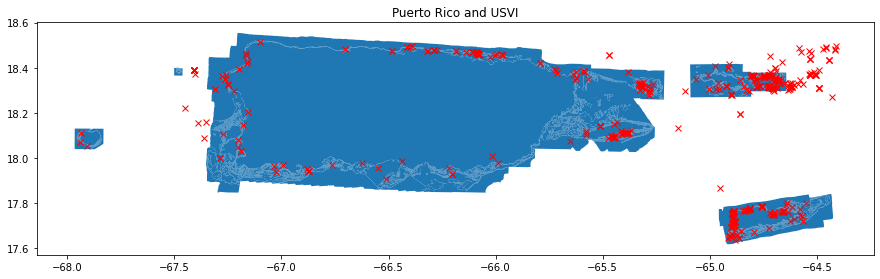

In [6]:
#some LF are on land and some outside the benthic mapping, they are not included in df
fig, ax = plt.subplots(figsize = (15, 15))
plt.plot(lf_df.Longitude, lf_df.Latitude, marker = 'x', color = 'r', linestyle = 'None')
plt.title('Puerto Rico and USVI')
gdf.plot(categorical=True, figsize=(10,10), markersize=45, ax=ax);

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7384 entries, 0 to 7383
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   DESCRIPTOR  7384 non-null   object
 1   ZONE        7384 non-null   object
 2   HABITAT     7384 non-null   object
 3   TYPE        7384 non-null   object
 4   polyid      7384 non-null   object
 5   num_lf      7384 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 346.2+ KB


In [8]:
d_unique = df.DESCRIPTOR.unique()
z_unique = df.ZONE.unique()
h_unique = df.HABITAT.unique()
t_unique = df.TYPE.unique()

In [9]:
#total potetial combinations
print('Total Potential Combinations of Zone, Descriptor, Habitat, and Type: {}'.format(len(d_unique)* len(z_unique)\
                                                                                       * len(h_unique)* len(t_unique)))

Total Potential Combinations of Zone, Descriptor, Habitat, and Type: 19665


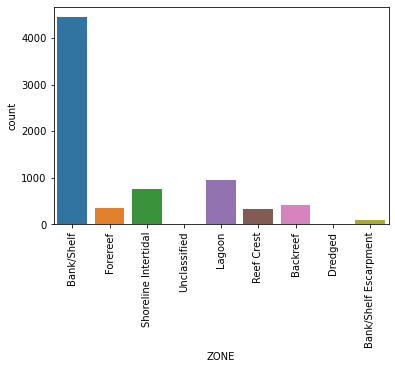

In [10]:
plt.xticks(rotation = 90)
sn.countplot(x = df.ZONE, data = df.query('num_lf == 0'));

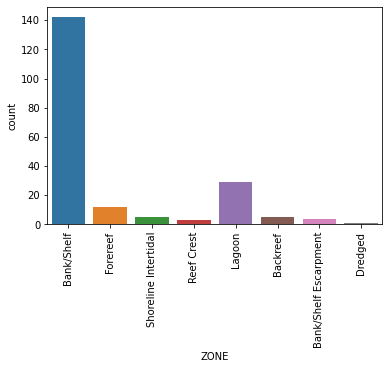

In [11]:
plt.xticks(rotation = 90)
sn.countplot(x = 'ZONE', data = df.query('num_lf > 0'));

In [12]:
def elbow_plot(data):
    sse = {}
    for k in range(1, 25):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        sse[k] = kmeans.inertia_
    plt.title('Elbow plot for K selection')
    plt.xlabel('k')
    sn.pointplot(x=list(sse.keys()),
                 y=list(sse.values()))
    plt.show()
k_train = pd.get_dummies(df[['DESCRIPTOR', 'ZONE', 'HABITAT', 'TYPE']], drop_first = False)
#elbow_plot(k_train)

In [ ]:
n_clusters = 21
kmeans = KMeans(n_clusters= n_clusters)
kmeans.fit(k_train)

In [14]:
t_clusters = kmeans.predict(k_train)
df['clusters'] = t_clusters

In [15]:
df.sample(25)

,DESCRIPTOR,ZONE,HABITAT,TYPE,polyid,num_lf,clusters
2392,Mangrove,Shoreline Intertidal,Other Delineations,Mangrove,PR_1258,0,5
5609,Reef/Scattered Coral-Rock,Bank/Shelf,Coral Reef and Colonized Hardbottom,Scattered Coral/Rock in Unconsolidated Sediment,PR_4648,0,1
4203,Reef/Colonized Pavement,Bank/Shelf,Coral Reef and Colonized Hardbottom,Colonized Pavement,PR_3115,0,4
3147,Reef/Scattered Coral-Rock,Bank/Shelf,Coral Reef and Colonized Hardbottom,Scattered Coral/Rock in Unconsolidated Sediment,PR_2041,0,1
4226,Reef/Colonized Pavement with Channels,Bank/Shelf,Coral Reef and Colonized Hardbottom,Colonized Pavement with Sand Channels,PR_3140,0,9
1638,Reef/Patch Reef (Individual),Bank/Shelf,Coral Reef and Colonized Hardbottom,Patch Reef (Individual),PR_484,0,7
5599,Reef/Scattered Coral-Rock,Bank/Shelf,Coral Reef and Colonized Hardbottom,Scattered Coral/Rock in Unconsolidated Sediment,PR_4635,0,1
4110,Seagrass/Patchy/10-30%,Bank/Shelf,Submerged Vegetation,Seagrass,PR_3021,0,14
4111,Reef/Scattered Coral-Rock,Bank/Shelf,Coral Reef and Colonized Hardbottom,Scattered Coral/Rock in Unconsolidated Sediment,PR_3022,0,1
4621,Reef/Colonized Bedrock,Shoreline Intertidal,Coral Reef and Colonized Hardbottom,Colonized Bedrock,PR_3563,0,8


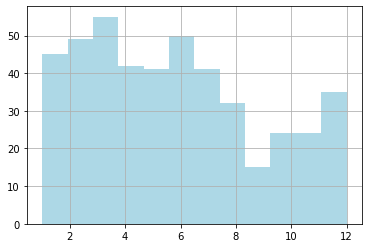

In [16]:
lf_df.Month.hist(color = 'lightblue', bins = 12);

https://travel.usnews.com/US_Virgin_Islands/When_To_Visit/
The best time to visit the U.S. Virgin Islands is April to June, when you can expect mild weather and very little rainfall. In the USVI's peak season, from December to March, the temperature ranges from the mid-70s to high 80s with breezy evenings. July to October is the region's hurricane season with average temps in the upper 80s.

https://www.caribeez.com/us-virgin-islands/article/best-and-worst-months-to-visit-the-u.s.-virgin-islands
The best times to visit the U.S. Virgin Islands are December through April during the dry season. The warmer months of March and April are even better. But the best times also depend on what visitors plan to do when they get there. Some months are better than others for spending time on the beaches and in the water. The worst times to visit St. Thomas and the U.S. Virgin Islands are September through November. These months fall inside the heart of the Virgin Islands hurricane season, also known as the rainy season.

peak 12-3, 4-6, Hurricane Season 7-10
best 12-4, worst 9-11

???12-2, 3-5, 6-8, 9-11???
???8-11, 12-3, 4-7???

Null Hypothesis: The mean number of lionfish captured is not reduced during low tourism seasons.
Alternative Hypotheis: The mean number of lionfish captured is correclated with seasonal tourist patterns.

In [72]:
low_season = len(lf_df.query('Month >= 9 and Month <=11'))/3
print('The mean number of reported lionfish during the months of September through November is {}' .format(low_season))

The mean number of reported lionfish during the months of September through November is 21.0


In [102]:
season_cnts = []
def seasonal_count(t_df, rands):
    lens = []
    for r in rands:
        lens.append(len(t_df.query('Month == {}' .format(r))))
    season_cnts.append(np.sum(lens)/3)
for i in range(10000):
    temp_df = lf_df[lf_df['Month'].notna()]
    rand_months = np.random.choice([1,2,3,4,5,6,7,8,9,10,11,12], size = 3)
    seasonal_count(temp_df, rand_months)

9957


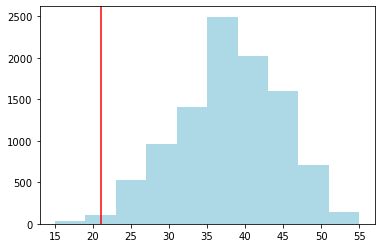

In [103]:
plt.axvline(x = low_season, color = 'r')
plt.hist(season_cnts, color = 'lightblue');

In [111]:
1 - np.sum([np.array(season_cnts) > low_season])/10000

0.0121

Conclusion: With a p-value of .0121 the null hypothesis is rejected.

In [21]:
id_df = df[['polyid', 'clusters']]
gdf = pd.merge(gdf, id_df, on = 'polyid')
gdf.head()

,POLYGONID,AREA,ID,DESCRIPTOR,ZONE,HABITAT,TYPE,MODIFIER1,MODIFIER2,MODIFIER3,polyid,geometry,clusters
0,1,6445.33,11,Sand,Bank/Shelf,Unconsolidated Sediments,Sand,None,None,None,STJ_1,"POLYGON ((-64.80970 18.36644, -64.80955 18.366...",6
1,2,47409.30,11,Sand,Bank/Shelf,Unconsolidated Sediments,Sand,None,None,None,STJ_2,"POLYGON ((-64.80417 18.35974, -64.80419 18.359...",6
2,3,44504.30,35,Reef/Scattered Coral-Rock,Bank/Shelf,Coral Reef and Colonized Hardbottom,Scattered Coral/Rock in Unconsolidated,None,None,None,STJ_3,"POLYGON ((-64.81332 18.35635, -64.81342 18.356...",1
3,4,5698.10,35,Reef/Scattered Coral-Rock,Bank/Shelf,Coral Reef and Colonized Hardbottom,Scattered Coral/Rock in Unconsolidated,None,None,None,STJ_4,"POLYGON ((-64.81626 18.34365, -64.81617 18.344...",1
4,5,24547.68,31,Reef/Linear Reef,Forereef,Coral Reef and Colonized Hardbottom,Linear Reef,None,None,None,STJ_5,"POLYGON ((-64.79880 18.35579, -64.79875 18.355...",3


In [22]:
cluster_prob = []
for c in range(n_clusters):
    #print(c)
    cluster_id = c
    cluster_ = df.query('clusters == {}' .format(cluster_id))
    lf_w_cluster = df.query('num_lf >= 1')
    lf_w_cluster_ = lf_w_cluster.query('clusters == {}' .format(cluster_id))
    p_lf = 201/7384
    p_C = len(cluster_)/len(df)
    p_C_lf = len(lf_w_cluster_)/len(lf_w_cluster)
    cluster_prob.append((p_C_lf * p_lf)/ p_C)
    print('Cluster id: {}, Probability: {}' .format(c, (p_C_lf * p_lf)/ p_C))

Cluster id: 0, Probability: 0.029411764705882353
Cluster id: 1, Probability: 0.017150395778364115
Cluster id: 2, Probability: 0.024169184290030208
Cluster id: 3, Probability: 0.03752759381898455
Cluster id: 4, Probability: 0.02998500749625188
Cluster id: 5, Probability: 0.010554089709762533
Cluster id: 6, Probability: 0.04075235109717869
Cluster id: 7, Probability: 0.0
Cluster id: 8, Probability: 0.07296137339055796
Cluster id: 9, Probability: 0.04777070063694267
Cluster id: 10, Probability: 0.015384615384615384
Cluster id: 11, Probability: 0.005037783375314861
Cluster id: 12, Probability: 0.0
Cluster id: 13, Probability: 0.034482758620689655
Cluster id: 14, Probability: 0.03812316715542522
Cluster id: 15, Probability: 0.043478260869565216
Cluster id: 16, Probability: 0.036303630363036306
Cluster id: 17, Probability: 0.02253521126760563
Cluster id: 18, Probability: 0.009345794392523364
Cluster id: 19, Probability: 0.044843049327354265
Cluster id: 20, Probability: 0.04000000000000001


In [23]:
cluster_prob_scaled = MinMaxScaler(feature_range=(0,1)).fit_transform(np.array(cluster_prob).reshape(-1,1))

In [112]:
cluster_prob_scaled

array([[0.40311419],
       [0.23506131],
       [0.33126   ],
       [0.51434879],
       [0.41097099],
       [0.14465311],
       [0.55854693],
       [0.        ],
       [1.        ],
       [0.6547396 ],
       [0.21085973],
       [0.06904727],
       [0.        ],
       [0.47261663],
       [0.52251164],
       [0.59590793],
       [0.49757329],
       [0.30886495],
       [0.12809236],
       [0.61461356],
       [0.54823529]])

In [24]:
cluster_probs = []
def print_me(x):
    cluster_probs.append(cluster_prob_scaled[x][0])
_ = gdf['clusters'].apply(print_me)

In [25]:
gdf['rel_probs'] = cluster_probs 
gdf.head()

,POLYGONID,AREA,ID,DESCRIPTOR,ZONE,HABITAT,TYPE,MODIFIER1,MODIFIER2,MODIFIER3,polyid,geometry,clusters,rel_probs
0,1,6445.33,11,Sand,Bank/Shelf,Unconsolidated Sediments,Sand,None,None,None,STJ_1,"POLYGON ((-64.80970 18.36644, -64.80955 18.366...",6,0.558547
1,2,47409.30,11,Sand,Bank/Shelf,Unconsolidated Sediments,Sand,None,None,None,STJ_2,"POLYGON ((-64.80417 18.35974, -64.80419 18.359...",6,0.558547
2,3,44504.30,35,Reef/Scattered Coral-Rock,Bank/Shelf,Coral Reef and Colonized Hardbottom,Scattered Coral/Rock in Unconsolidated,None,None,None,STJ_3,"POLYGON ((-64.81332 18.35635, -64.81342 18.356...",1,0.235061
3,4,5698.10,35,Reef/Scattered Coral-Rock,Bank/Shelf,Coral Reef and Colonized Hardbottom,Scattered Coral/Rock in Unconsolidated,None,None,None,STJ_4,"POLYGON ((-64.81626 18.34365, -64.81617 18.344...",1,0.235061
4,5,24547.68,31,Reef/Linear Reef,Forereef,Coral Reef and Colonized Hardbottom,Linear Reef,None,None,None,STJ_5,"POLYGON ((-64.79880 18.35579, -64.79875 18.355...",3,0.514349


In [26]:
gdf.drop(['MODIFIER1', 'MODIFIER2', 'MODIFIER3', 'AREA', 'POLYGONID', 'ID'], axis = 1, inplace = True)

In [27]:
gdf.head(3)

,DESCRIPTOR,ZONE,HABITAT,TYPE,polyid,geometry,clusters,rel_probs
0,Sand,Bank/Shelf,Unconsolidated Sediments,Sand,STJ_1,"POLYGON ((-64.80970 18.36644, -64.80955 18.366...",6,0.558547
1,Sand,Bank/Shelf,Unconsolidated Sediments,Sand,STJ_2,"POLYGON ((-64.80417 18.35974, -64.80419 18.359...",6,0.558547
2,Reef/Scattered Coral-Rock,Bank/Shelf,Coral Reef and Colonized Hardbottom,Scattered Coral/Rock in Unconsolidated,STJ_3,"POLYGON ((-64.81332 18.35635, -64.81342 18.356...",1,0.235061


In [113]:
gdf.query('clusters == 4')

,DESCRIPTOR,ZONE,HABITAT,TYPE,polyid,geometry,clusters,rel_probs
20,Reef/Colonized Pavement,Bank/Shelf,Coral Reef and Colonized Hardbottom,Colonized Pavement,STJ_22,"POLYGON ((-64.78947 18.34258, -64.78959 18.342...",4,0.410971
59,Reef/Colonized Pavement,Bank/Shelf,Coral Reef and Colonized Hardbottom,Colonized Pavement,STJ_67,"POLYGON ((-64.77880 18.34972, -64.77878 18.349...",4,0.410971
88,Reef/Colonized Pavement,Bank/Shelf,Coral Reef and Colonized Hardbottom,Colonized Pavement,STJ_98,"POLYGON ((-64.67782 18.33869, -64.67763 18.338...",4,0.410971
97,Reef/Colonized Pavement,Bank/Shelf,Coral Reef and Colonized Hardbottom,Colonized Pavement,STJ_107,"POLYGON ((-64.69156 18.33731, -64.69146 18.337...",4,0.410971
100,Reef/Colonized Pavement,Bank/Shelf,Coral Reef and Colonized Hardbottom,Colonized Pavement,STJ_110,"POLYGON ((-64.69269 18.34734, -64.69273 18.347...",4,0.410971
...,...,...,...,...,...,...,...,...
7337,Reef/Colonized Pavement,Bank/Shelf,Coral Reef and Colonized Hardbottom,Colonized Pavement,STC_1135,"POLYGON ((-64.71169 17.69735, -64.71172 17.697...",4,0.410971
7353,Reef/Colonized Pavement,Bank/Shelf,Coral Reef and Colonized Hardbottom,Colonized Pavement,STC_1154,"POLYGON ((-64.91208 17.66083, -64.91206 17.660...",4,0.410971
7359,Reef/Colonized Pavement,Bank/Shelf,Coral Reef and Colonized Hardbottom,Colonized Pavement,STC_1160,"POLYGON ((-64.65978 17.76982, -64.65977 17.769...",4,0.410971
7360,Reef/Colonized Pavement,Bank/Shelf,Coral Reef and Colonized Hardbottom,Colonized Pavement,STC_1161,"POLYGON ((-64.65743 17.76875, -64.65744 17.768...",4,0.410971


In [28]:
gdf.to_file('../data/processed/gdf_w_clusters.shp')